In [1]:
import pandas as pd
import numpy as np
import cPickle as pickle
from random import shuffle
from tqdm import tqdm
# import matplotlib.pyplot as plt
import random
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import evaluate_plot as eval_plot
import batchify as batchify
import dbm as dbm
from sklearn.metrics import precision_recall_fscore_support

import os
# 1 starts the process on GPU-0
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.__version__

'0.4.0'

In [2]:
data = pickle.load(open('../../Data/final_Physionet_avg_new.pkl','rb'))

In [3]:
# # This is just for testing
# data['train_ids'] = data['train_ids'][:5]
# data['val_ids'] = data['val_ids'][:5]
# data['test_ids'] = data['test_ids'][:5]

In [4]:
params = {'bilstm_flag':True,
        'hidden_dim' : 700,
        'dropout' : 0.9,
        'layers' : 1,
        'tagset_size' : 2,
        'bilstm_flag' : True,
        'attn_category' : 'dot',
        'num_features' : 37,
        'imputation_layer_dim_op':15,
        'selected_feats' : 5,
        'batch_size':1,
        'same_device':True,
        'same_feat_other_device':False,
        'model_name':'VDBM-Phy-3rd-'}
pickle.dump(params, open('../../Models/config_'+params['model_name']+'.pt','wb'))

In [5]:
model_RNN = dbm.RNN_osaka(params).cuda()
loss_function = nn.NLLLoss()
# optimizer = optim.Adam(model_RNN.parameters(), lr=0.01, weight_decay=0.00005)
optimizer = optim.SGD(model_RNN.parameters(), lr=0.0001, weight_decay=0.00000000002)

/home/bsingh/anaconda2/lib/python2.7/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Dot Attention is being used!


In [6]:
mode = 'normal'
if(mode=='normal'):
    feature_ind = 0
    label_ind = -1
    print "NORMAL mode with Flags"

NORMAL mode with Flags


In [7]:
batch_size = 1
epochs = 45
save_flag = True
dict_df_prf_mod = {}
print "==x=="*20
print "Data Statistics"
print "Train Data: "+str(len(data['train_ids']))
print "Val Data: "+str(len(data['val_ids']))
print "Test Data: "+str(len(data['test_ids']))
print "==x=="*20

==x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x==
Data Statistics
Train Data: 2517
Val Data: 630
Test Data: 787
==x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x====x==


  0%|          | 0/2517 [00:00<?, ?it/s]

=#==#==#==#==#=0=#==#==#==#==#=


100%|██████████| 2517/2517 [21:49<00:00,  1.92it/s]


==========Epoch No:0==========
Training Loss: 1565.97640365
Train: (0.6360030878699392, 0.6543504171632897, 0.5915595933547455, None)
                    0            1
Precision    0.590106     0.662489
Recall       0.181325     0.927318
F-score      0.277409     0.772846
Count      921.000000  1596.000000
--------
Val: (0.6497350138060034, 0.6555555555555556, 0.6516046359467774, None)
                    0           1
Precision    0.559633    0.706311
Recall       0.502058    0.751938
F-score      0.529284    0.728411
Count      243.000000  387.000000
--------
Test: (0.6525337490600507, 0.6607369758576874, 0.6546291062790556, None)
                    0           1
Precision    0.559055    0.709193
Recall       0.478114    0.771429
F-score      0.515426    0.739003
Count      297.000000  490.000000




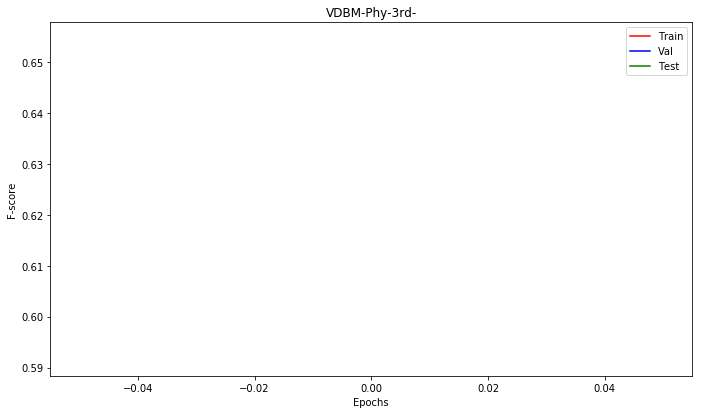

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch0========
TRAIN: (0.6360030878699392, 0.6543504171632897, 0.5915595933547455)
VAL: (0.6497350138060034, 0.6555555555555556, 0.6516046359467774)
TEST: (0.6525337490600507, 0.6607369758576874, 0.6546291062790556)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.590106     0.662489    0.559633    0.706311    0.559055   
Recall       0.181325     0.927318    0.502058    0.751938    0.478114   
F-score      0.277409     0.772846    0.529284    0.728411    0.515426   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.709193  
Recall       0.771429  
F-score      0.739003  
Count      490.000000  
=#==#==#==#==#=1=#==#==#==#==#=


100%|██████████| 2517/2517 [22:23<00:00,  1.87it/s]


==========Epoch No:1==========
Training Loss: 1467.86095485
Train: (0.6733901996852422, 0.6849423917361939, 0.6555640674009725, None)
                    0            1
Precision    0.630612     0.698076
Recall       0.335505     0.886591
F-score      0.437987     0.781121
Count      921.000000  1596.000000
--------
Val: (0.6707936438397316, 0.6746031746031746, 0.6722024696815722, None)
                    0           1
Precision    0.584071    0.725248
Recall       0.543210    0.757106
F-score      0.562900    0.740834
Count      243.000000  387.000000
--------
Test: (0.6541799582605483, 0.6607369758576874, 0.656284653492194, None)
                    0           1
Precision    0.556818    0.713193
Recall       0.494949    0.761224
F-score      0.524064    0.736426
Count      297.000000  490.000000




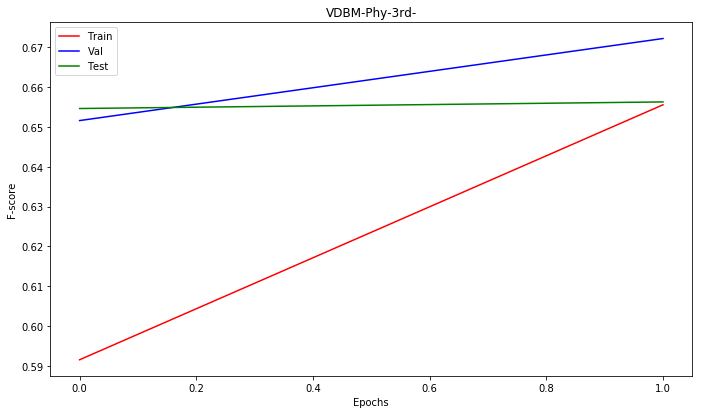

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch1========
TRAIN: (0.6733901996852422, 0.6849423917361939, 0.6555640674009725)
VAL: (0.6707936438397316, 0.6746031746031746, 0.6722024696815722)
TEST: (0.6541799582605483, 0.6607369758576874, 0.656284653492194)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.630612     0.698076    0.584071    0.725248    0.556818   
Recall       0.335505     0.886591    0.543210    0.757106    0.494949   
F-score      0.437987     0.781121    0.562900    0.740834    0.524064   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.713193  
Recall       0.761224  
F-score      0.736426  
Count      490.000000  
=#==#==#==#==#=2=#==#==#==#==#=


100%|██████████| 2517/2517 [21:58<00:00,  1.91it/s]


==========Epoch No:2==========
Training Loss: 1434.66131452
Train: (0.70374046293903, 0.7099721891140246, 0.6873511893641975, None)
                    0            1
Precision    0.677840     0.718687
Recall       0.395223     0.891604
F-score      0.499314     0.795861
Count      921.000000  1596.000000
--------
Val: (0.6844483288895772, 0.6888888888888889, 0.6858126841102063, None)
                    0           1
Precision    0.606335    0.733496
Recall       0.551440    0.775194
F-score      0.577586    0.753769
Count      243.000000  387.000000
--------
Test: (0.6675971604363996, 0.6734434561626429, 0.6694595550247044, None)
                    0           1
Precision    0.575188    0.723608
Recall       0.515152    0.769388
F-score      0.543517    0.745796
Count      297.000000  490.000000




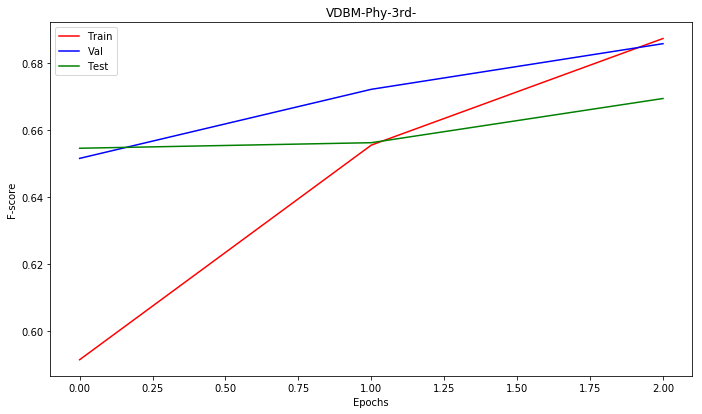

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch2========
TRAIN: (0.70374046293903, 0.7099721891140246, 0.6873511893641975)
VAL: (0.6844483288895772, 0.6888888888888889, 0.6858126841102063)
TEST: (0.6675971604363996, 0.6734434561626429, 0.6694595550247044)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.677840     0.718687    0.606335    0.733496    0.575188   
Recall       0.395223     0.891604    0.551440    0.775194    0.515152   
F-score      0.499314     0.795861    0.577586    0.753769    0.543517   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.723608  
Recall       0.769388  
F-score      0.745796  
Count      490.000000  
=#==#==#==#==#=3=#==#==#==#==#=


100%|██████████| 2517/2517 [22:22<00:00,  1.87it/s]


==========Epoch No:3==========
Training Loss: 1406.95639208
Train: (0.7082575992584896, 0.7155343663090982, 0.6979738999732764, None)
                    0            1
Precision    0.672850     0.728690
Recall       0.433225     0.878446
F-score      0.527081     0.796591
Count      921.000000  1596.000000
--------
Val: (0.6944828823922569, 0.6968253968253968, 0.6954391073224462, None)
                    0           1
Precision    0.612069    0.746231
Recall       0.584362    0.767442
F-score      0.597895    0.756688
Count      243.000000  387.000000
--------
Test: (0.658969966976939, 0.6645489199491741, 0.6609105861892982, None)
                    0           1
Precision    0.561338    0.718147
Recall       0.508418    0.759184
F-score      0.533569    0.738095
Count      297.000000  490.000000




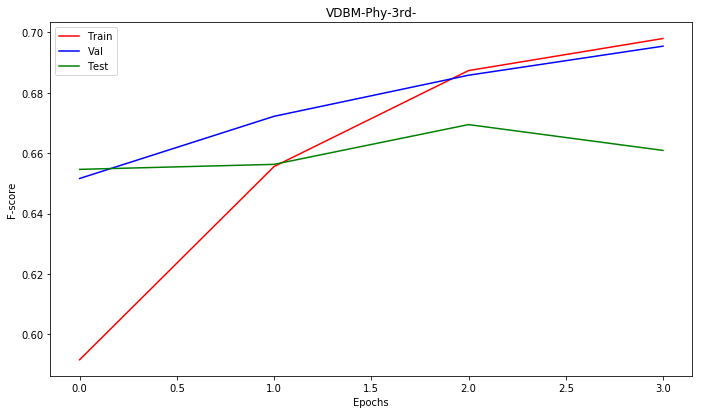

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch3========
TRAIN: (0.7082575992584896, 0.7155343663090982, 0.6979738999732764)
VAL: (0.6944828823922569, 0.6968253968253968, 0.6954391073224462)
TEST: (0.658969966976939, 0.6645489199491741, 0.6609105861892982)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.672850     0.728690    0.612069    0.746231    0.561338   
Recall       0.433225     0.878446    0.584362    0.767442    0.508418   
F-score      0.527081     0.796591    0.597895    0.756688    0.533569   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.718147  
Recall       0.759184  
F-score      0.738095  
Count      490.000000  
=#==#==#==#==#=4=#==#==#==#==#=


100%|██████████| 2517/2517 [22:25<00:00,  1.87it/s]


==========Epoch No:4==========
Training Loss: 1381.66365609
Train: (0.7185108223876634, 0.724274930472785, 0.7075537815289223, None)
                    0            1
Precision    0.690117     0.734896
Recall       0.447340     0.884085
F-score      0.542819     0.802617
Count      921.000000  1596.000000
--------
Val: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418, None)
                    0           1
Precision    0.617021    0.751899
Recall       0.596708    0.767442
F-score      0.606695    0.759591
Count      243.000000  387.000000
--------
Test: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011, None)
                    0           1
Precision    0.546763    0.715128
Recall       0.511785    0.742857
F-score      0.528696    0.728729
Count      297.000000  490.000000




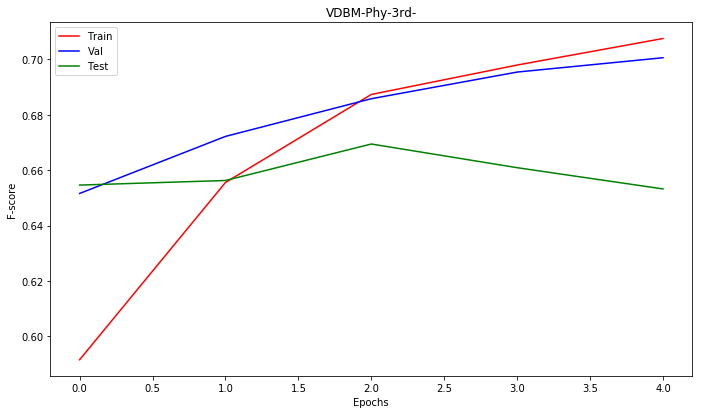

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch4========
TRAIN: (0.7185108223876634, 0.724274930472785, 0.7075537815289223)
VAL: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418)
TEST: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.690117     0.734896    0.617021    0.751899    0.546763   
Recall       0.447340     0.884085    0.596708    0.767442    0.511785   
F-score      0.542819     0.802617    0.606695    0.759591    0.528696   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.715128  
Recall       0.742857  
F-score      0.728729  
Count      490.000000  
=#==#==#==#==#=5=#==#==#==#==#=


 14%|█▍        | 350/2517 [03:06<19:12,  1.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [21:23<00:00,  1.96it/s]


==========Epoch No:5==========
Training Loss: 1362.50843507
Train: (0.720161750050529, 0.7258641239570918, 0.7096814546205928, None)
                    0            1
Precision    0.691542     0.736677
Recall       0.452769     0.883459
F-score      0.547244     0.803419
Count      921.000000  1596.000000
--------
Val: (0.6975172095398101, 0.6984126984126984, 0.6979365875140764, None)
                    0           1
Precision    0.610879    0.751918
Recall       0.600823    0.759690
F-score      0.605809    0.755784
Count      243.000000  387.000000
--------
Test: (0.6600985367029751, 0.6658195679796697, 0.6620456507193543, None)
                    0           1
Precision    0.563433    0.718690
Recall       0.508418    0.761224
F-score      0.534513    0.739346
Count      297.000000  490.000000




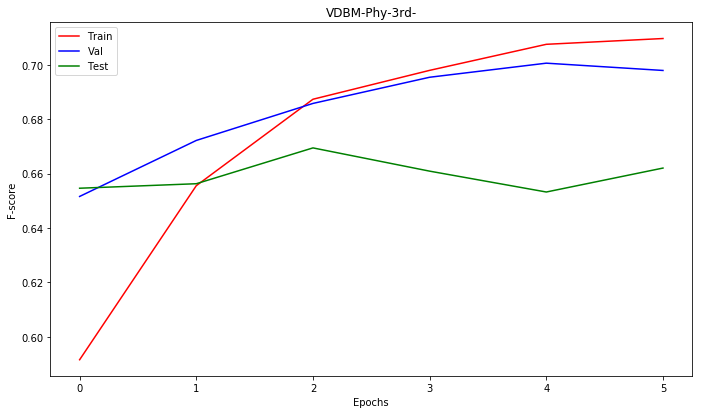

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch4========
TRAIN: (0.7185108223876634, 0.724274930472785, 0.7075537815289223)
VAL: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418)
TEST: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.690117     0.734896    0.617021    0.751899    0.546763   
Recall       0.447340     0.884085    0.596708    0.767442    0.511785   
F-score      0.542819     0.802617    0.606695    0.759591    0.528696   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.715128  
Recall       0.742857  
F-score      0.728729  
Count      490.000000  
=#==#==#==#==#=6=#==#==#==#==#=


100%|██████████| 2517/2517 [21:27<00:00,  1.95it/s]


==========Epoch No:6==========
Training Loss: 1347.61038527
Train: (0.7311403702294933, 0.7357965832340088, 0.7213769730924601, None)
                    0            1
Precision    0.706452     0.745387
Recall       0.475570     0.885965
F-score      0.568462     0.809619
Count      921.000000  1596.000000
--------
Val: (0.6987419162636143, 0.7015873015873015, 0.6998125637590492, None)
                    0           1
Precision    0.620087    0.748130
Recall       0.584362    0.775194
F-score      0.601695    0.761421
Count      243.000000  387.000000
--------
Test: (0.6612317268842547, 0.6670902160101652, 0.6631804371061346, None)
                    0           1
Precision    0.565543    0.719231
Recall       0.508418    0.763265
F-score      0.535461    0.740594
Count      297.000000  490.000000




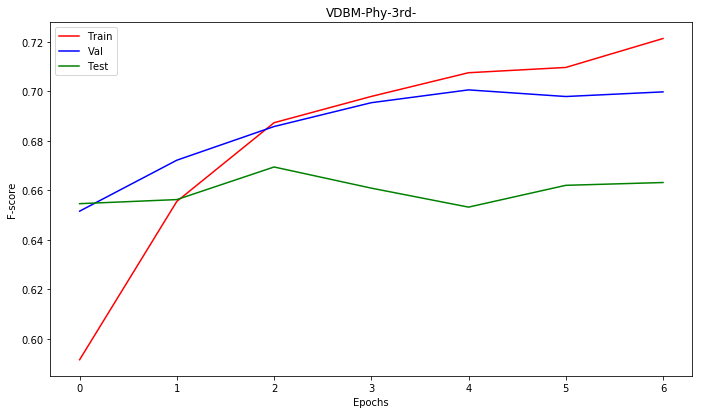

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch4========
TRAIN: (0.7185108223876634, 0.724274930472785, 0.7075537815289223)
VAL: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418)
TEST: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.690117     0.734896    0.617021    0.751899    0.546763   
Recall       0.447340     0.884085    0.596708    0.767442    0.511785   
F-score      0.542819     0.802617    0.606695    0.759591    0.528696   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.715128  
Recall       0.742857  
F-score      0.728729  
Count      490.000000  
=#==#==#==#==#=7=#==#==#==#==#=


  2%|▏         | 61/2517 [00:31<21:11,  1.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [24:08<00:00,  1.74it/s]


==========Epoch No:7==========
Training Loss: 1334.08686069
Train: (0.7336695414489522, 0.7381803734604688, 0.7242919263843891, None)
                    0            1
Precision    0.709265     0.747753
Recall       0.482085     0.885965
F-score      0.574014     0.811012
Count      921.000000  1596.000000
--------
Val: (0.6951350140056022, 0.692063492063492, 0.6933488735594798, None)
                    0           1
Precision    0.596078    0.757333
Recall       0.625514    0.733850
F-score      0.610442    0.745407
Count      243.000000  387.000000
--------
Test: (0.676962830440919, 0.6747141041931385, 0.67573013680959, None)
                    0           1
Precision    0.566775    0.743750
Recall       0.585859    0.728571
F-score      0.576159    0.736082
Count      297.000000  490.000000




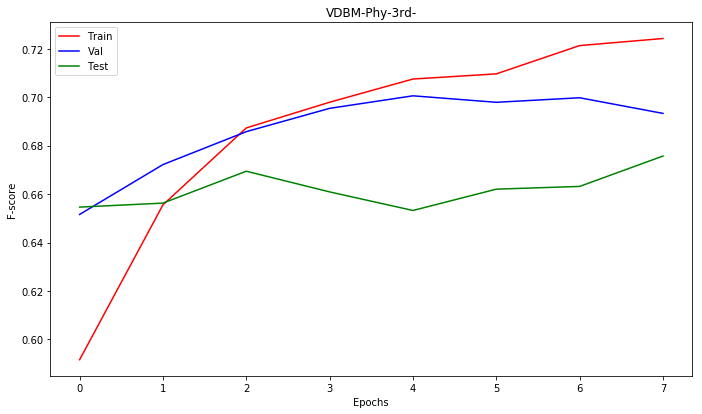

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch4========
TRAIN: (0.7185108223876634, 0.724274930472785, 0.7075537815289223)
VAL: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418)
TEST: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.690117     0.734896    0.617021    0.751899    0.546763   
Recall       0.447340     0.884085    0.596708    0.767442    0.511785   
F-score      0.542819     0.802617    0.606695    0.759591    0.528696   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.715128  
Recall       0.742857  
F-score      0.728729  
Count      490.000000  
=#==#==#==#==#=8=#==#==#==#==#=


100%|██████████| 2517/2517 [24:40<00:00,  1.70it/s]


==========Epoch No:8==========
Training Loss: 1313.90588769
Train: (0.7454353232450408, 0.7485101311084624, 0.7354235760227908, None)
                    0            1
Precision    0.728571     0.755167
Recall       0.498371     0.892857
F-score      0.591876     0.818260
Count      921.000000  1596.000000
--------
Val: (0.697090586161994, 0.6984126984126984, 0.6976877289377289, None)
                    0           1
Precision    0.611814    0.750636
Recall       0.596708    0.762274
F-score      0.604167    0.756410
Count      243.000000  387.000000
--------
Test: (0.6723833520669086, 0.6734434561626429, 0.6728862164491148, None)
                    0           1
Precision    0.568493    0.735354
Recall       0.558923    0.742857
F-score      0.563667    0.739086
Count      297.000000  490.000000




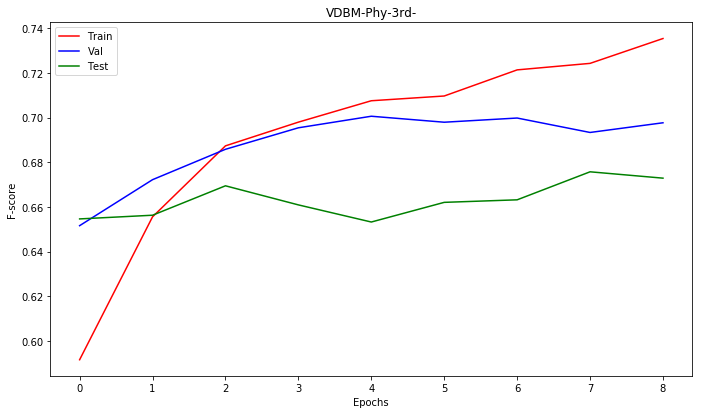

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch4========
TRAIN: (0.7185108223876634, 0.724274930472785, 0.7075537815289223)
VAL: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418)
TEST: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.690117     0.734896    0.617021    0.751899    0.546763   
Recall       0.447340     0.884085    0.596708    0.767442    0.511785   
F-score      0.542819     0.802617    0.606695    0.759591    0.528696   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.715128  
Recall       0.742857  
F-score      0.728729  
Count      490.000000  
=#==#==#==#==#=9=#==#==#==#==#=


100%|██████████| 2517/2517 [23:58<00:00,  1.75it/s]


==========Epoch No:9==========
Training Loss: 1297.88633278
Train: (0.7399501167458863, 0.744139849026619, 0.731524382700384, None)
                    0            1
Precision    0.716069     0.753731
Recall       0.498371     0.885965
F-score      0.587708     0.814516
Count      921.000000  1596.000000
--------
Val: (0.6972147595070153, 0.6952380952380952, 0.6961143569910919, None)
                    0           1
Precision    0.601594    0.757256
Recall       0.621399    0.741602
F-score      0.611336    0.749347
Count      243.000000  387.000000
--------
Test: (0.6658349158010938, 0.6632782719186785, 0.664428161298748, None)
                    0           1
Precision    0.551948    0.734864
Recall       0.572391    0.718367
F-score      0.561983    0.726522
Count      297.000000  490.000000




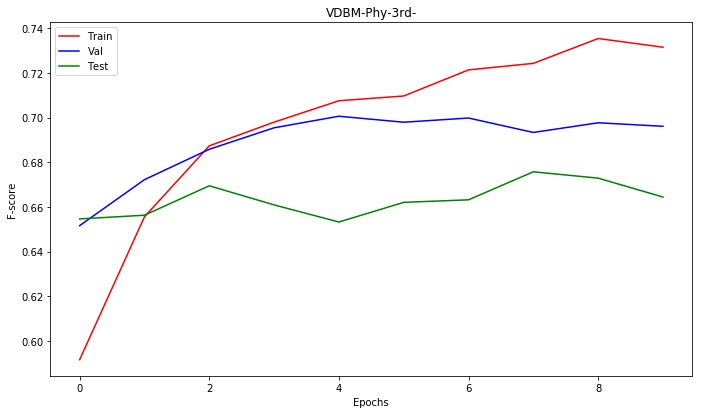

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch4========
TRAIN: (0.7185108223876634, 0.724274930472785, 0.7075537815289223)
VAL: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418)
TEST: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.690117     0.734896    0.617021    0.751899    0.546763   
Recall       0.447340     0.884085    0.596708    0.767442    0.511785   
F-score      0.542819     0.802617    0.606695    0.759591    0.528696   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.715128  
Recall       0.742857  
F-score      0.728729  
Count      490.000000  
=#==#==#==#==#=10=#==#==#==#==#=


100%|██████████| 2517/2517 [22:25<00:00,  1.87it/s]


==========Epoch No:10==========
Training Loss: 1281.01742525
Train: (0.7523103404996997, 0.7556615017878426, 0.7447274831958572, None)
                    0            1
Precision    0.731818     0.764136
Recall       0.524430     0.889098
F-score      0.611006     0.821894
Count      921.000000  1596.000000
--------
Val: (0.7002314618194173, 0.7, 0.7001139590544322, None)
                    0           1
Precision    0.610656    0.756477
Recall       0.613169    0.754522
F-score      0.611910    0.755498
Count      243.000000  387.000000
--------
Test: (0.6753485077157533, 0.6759847522236341, 0.6756568066485317, None)
                    0           1
Precision    0.571429    0.738337
Recall       0.565657    0.742857
F-score      0.568528    0.740590
Count      297.000000  490.000000




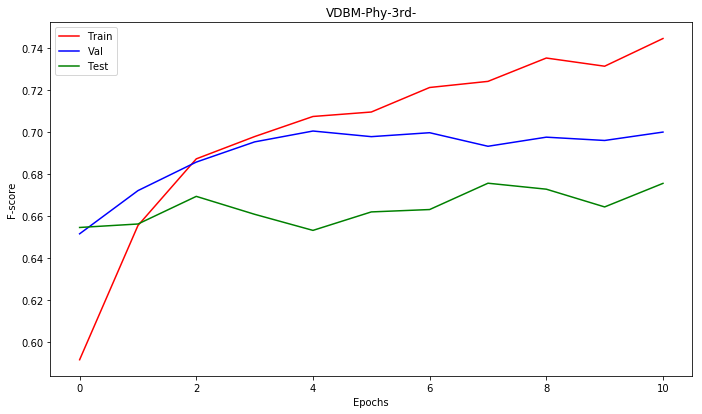

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch4========
TRAIN: (0.7185108223876634, 0.724274930472785, 0.7075537815289223)
VAL: (0.6998745719672194, 0.7015873015873015, 0.7006165318592418)
TEST: (0.6515896605876791, 0.6556543837357052, 0.6532397532055011)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.690117     0.734896    0.617021    0.751899    0.546763   
Recall       0.447340     0.884085    0.596708    0.767442    0.511785   
F-score      0.542819     0.802617    0.606695    0.759591    0.528696   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.715128  
Recall       0.742857  
F-score      0.728729  
Count      490.000000  
=#==#==#==#==#=11=#==#==#==#==#=


100%|██████████| 2517/2517 [23:42<00:00,  1.77it/s]


==========Epoch No:11==========
Training Loss: 1267.95706841
Train: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127, None)
                    0            1
Precision    0.738998     0.766416
Recall       0.528773     0.892231
F-score      0.616456     0.824551
Count      921.000000  1596.000000
--------
Val: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202, None)
                    0           1
Precision    0.606178    0.768194
Recall       0.646091    0.736434
F-score      0.625498    0.751979
Count      243.000000  387.000000
--------
Test: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539, None)
                    0           1
Precision    0.549020    0.731809
Recall       0.565657    0.718367
F-score      0.557214    0.725026
Count      297.000000  490.000000




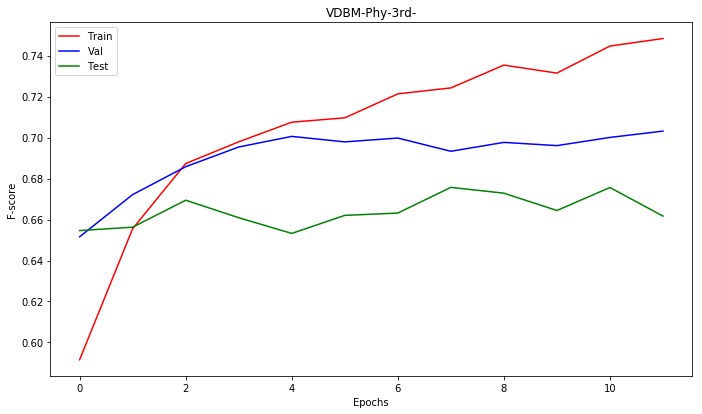

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=12=#==#==#==#==#=


100%|██████████| 2517/2517 [24:51<00:00,  1.69it/s]


==========Epoch No:12==========
Training Loss: 1257.14895478
Train: (0.7559767305489845, 0.7588398887564561, 0.7479346825848028, None)
                    0            1
Precision    0.738602     0.766003
Recall       0.527687     0.892231
F-score      0.615579     0.824313
Count      921.000000  1596.000000
--------
Val: (0.6969875023873185, 0.6936507936507936, 0.6950246654375015, None)
                    0           1
Precision    0.597656    0.759358
Recall       0.629630    0.733850
F-score      0.613226    0.746386
Count      243.000000  387.000000
--------
Test: (0.6704104191584571, 0.6683608640406608, 0.669298835373746, None)
                    0           1
Precision    0.558824    0.738046
Recall       0.575758    0.724490
F-score      0.567164    0.731205
Count      297.000000  490.000000




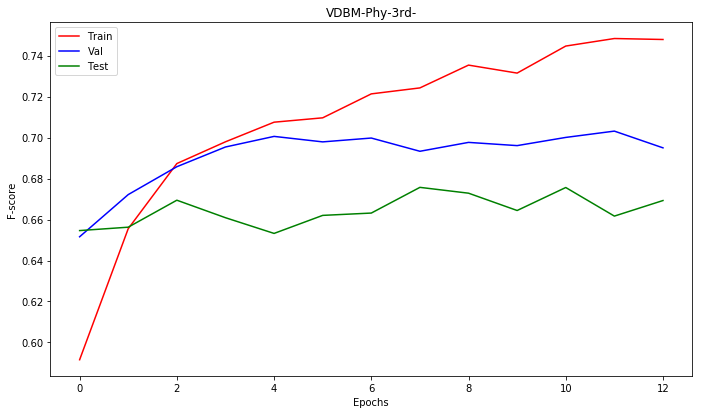

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=13=#==#==#==#==#=


100%|██████████| 2517/2517 [24:30<00:00,  1.71it/s]


==========Epoch No:13==========
Training Loss: 1238.38771689
Train: (0.7594549500300362, 0.7628128724672228, 0.753497681168988, None)
                    0            1
Precision    0.736842     0.772504
Recall       0.547231     0.887218
F-score      0.628037     0.825897
Count      921.000000  1596.000000
--------
Val: (0.7012741312741312, 0.6968253968253968, 0.6985444194617162, None)
                    0           1
Precision    0.600000    0.764865
Recall       0.641975    0.731266
F-score      0.620278    0.747688
Count      243.000000  387.000000
--------
Test: (0.6633762462477087, 0.6569250317662008, 0.6594435133920735, None)
                    0           1
Precision    0.541796    0.737069
Recall       0.589226    0.697959
F-score      0.564516    0.716981
Count      297.000000  490.000000




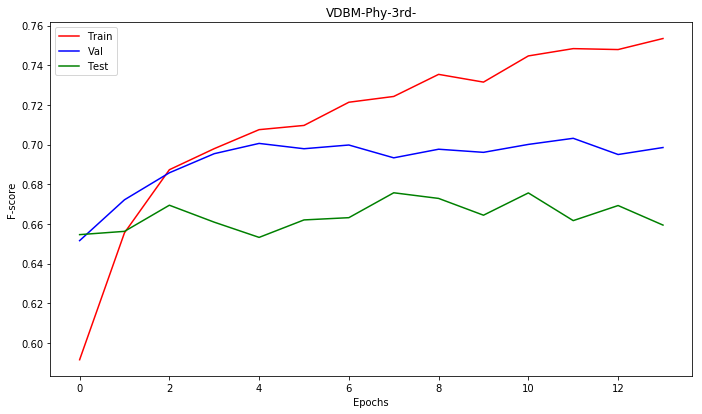

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=14=#==#==#==#==#=


100%|██████████| 2517/2517 [24:43<00:00,  1.70it/s]


==========Epoch No:14==========
Training Loss: 1232.60052076
Train: (0.7641274043828413, 0.7671831545490664, 0.7582962597242333, None)
                    0            1
Precision    0.743106     0.776258
Recall       0.555917     0.889098
F-score      0.636025     0.828855
Count      921.000000  1596.000000
--------
Val: (0.6958994708994708, 0.6936507936507936, 0.6946337322807911, None)
                    0           1
Precision    0.599206    0.756614
Recall       0.621399    0.739018
F-score      0.610101    0.747712
Count      243.000000  387.000000
--------
Test: (0.662785225874691, 0.6594663278271918, 0.660919310457792, None)
                    0           1
Precision    0.546624    0.733193
Recall       0.572391    0.712245
F-score      0.559211    0.722567
Count      297.000000  490.000000




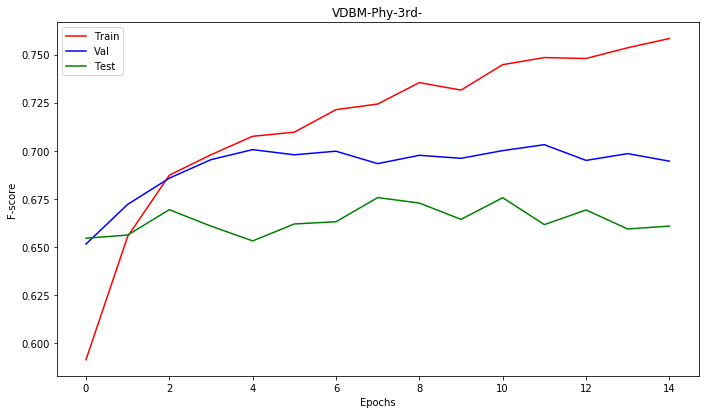

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=15=#==#==#==#==#=


100%|██████████| 2517/2517 [24:15<00:00,  1.73it/s]


==========Epoch No:15==========
Training Loss: 1218.56569543
Train: (0.7733448384002664, 0.7759237187127532, 0.7679514536047896, None)
                    0            1
Precision    0.754636     0.784141
Recall       0.574376     0.892231
F-score      0.652281     0.834701
Count      921.000000  1596.000000
--------
Val: (0.6931220014777967, 0.6888888888888889, 0.6905633403063209, None)
                    0           1
Precision    0.590734    0.757412
Recall       0.629630    0.726098
F-score      0.609562    0.741425
Count      243.000000  387.000000
--------
Test: (0.6632854147211309, 0.6594663278271918, 0.6611063376217524, None)
                    0           1
Precision    0.546326    0.734177
Recall       0.575758    0.710204
F-score      0.560656    0.721992
Count      297.000000  490.000000




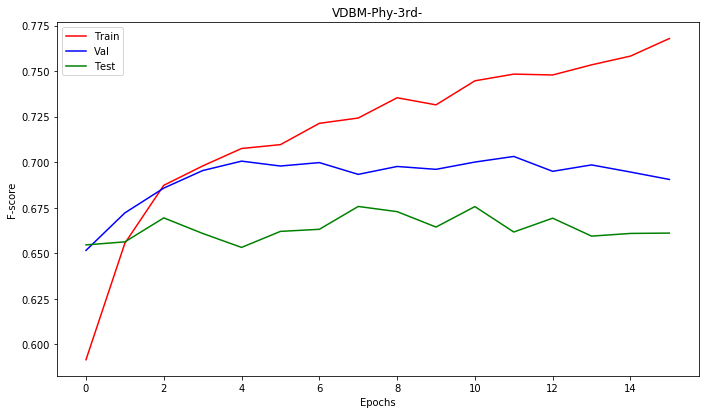

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=16=#==#==#==#==#=


100%|██████████| 2517/2517 [25:52<00:00,  1.62it/s]


==========Epoch No:16==========
Training Loss: 1200.28362679
Train: (0.779044878660317, 0.7810885975367501, 0.773253410583255, None)
                    0            1
Precision    0.764286     0.787562
Recall       0.580890     0.896617
F-score      0.660086     0.838558
Count      921.000000  1596.000000
--------
Val: (0.702043487852592, 0.692063492063492, 0.6950564300564301, None)
                    0           1
Precision    0.588448    0.773371
Recall       0.670782    0.705426
F-score      0.626923    0.737838
Count      243.000000  387.000000
--------
Test: (0.6544364470714529, 0.6467598475222364, 0.6496737212496593, None)
                    0           1
Precision    0.529052    0.730435
Recall       0.582492    0.685714
F-score      0.554487    0.707368
Count      297.000000  490.000000




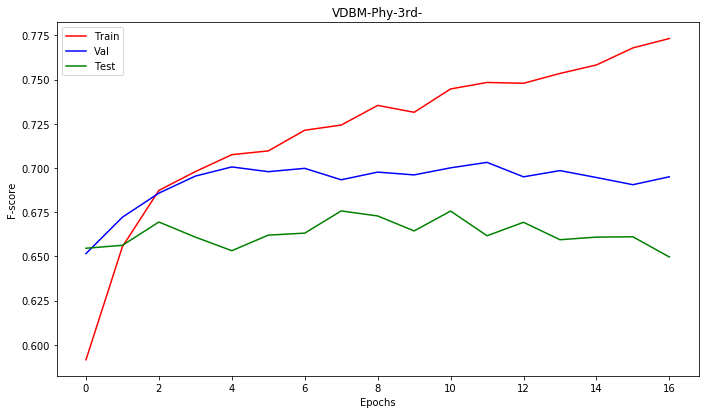

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=17=#==#==#==#==#=


100%|██████████| 2517/2517 [24:57<00:00,  1.68it/s]


==========Epoch No:17==========
Training Loss: 1186.6305995
Train: (0.7795972444216323, 0.7814858959078268, 0.7735244709720078, None)
                    0            1
Precision    0.766141     0.787363
Recall       0.579805     0.897870
F-score      0.660074     0.838993
Count      921.000000  1596.000000
--------
Val: (0.6994120034551302, 0.6952380952380952, 0.6968783741776204, None)
                    0           1
Precision    0.598456    0.762803
Recall       0.637860    0.731266
F-score      0.617530    0.746702
Count      243.000000  387.000000
--------
Test: (0.6537236448215709, 0.6493011435832274, 0.65117751327483, None)
                    0           1
Precision    0.533333    0.726695
Recall       0.565657    0.700000
F-score      0.549020    0.713098
Count      297.000000  490.000000




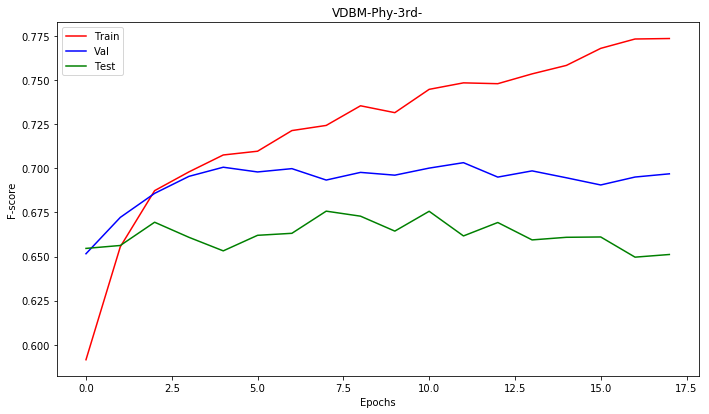

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=18=#==#==#==#==#=


100%|██████████| 2517/2517 [24:42<00:00,  1.70it/s]


==========Epoch No:18==========
Training Loss: 1175.08475855
Train: (0.7830952463350964, 0.7850615812475169, 0.7777321813424339, None)
                    0            1
Precision    0.768362     0.791598
Recall       0.590662     0.897243
F-score      0.667894     0.841116
Count      921.000000  1596.000000
--------
Val: (0.7003497537448123, 0.6888888888888889, 0.6921382343179555, None)
                    0           1
Precision    0.583630    0.773639
Recall       0.674897    0.697674
F-score      0.625954    0.733696
Count      243.000000  387.000000
--------
Test: (0.6621106653179035, 0.6531130876747141, 0.6563403226830987, None)
                    0           1
Precision    0.536145    0.738462
Recall       0.599327    0.685714
F-score      0.565978    0.711111
Count      297.000000  490.000000




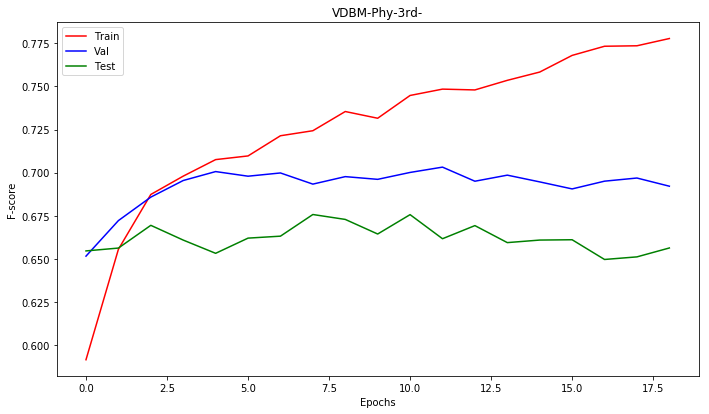

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=19=#==#==#==#==#=


100%|██████████| 2517/2517 [24:51<00:00,  1.69it/s]


==========Epoch No:19==========
Training Loss: 1158.99501577
Train: (0.7886153958791141, 0.7902264600715138, 0.7832044926742162, None)
                    0            1
Precision    0.776371     0.795681
Recall       0.599349     0.900376
F-score      0.676471     0.844797
Count      921.000000  1596.000000
--------
Val: (0.6937234131593206, 0.6857142857142857, 0.6883764736739357, None)
                    0           1
Precision    0.583026    0.763231
Recall       0.650206    0.708010
F-score      0.614786    0.734584
Count      243.000000  387.000000
--------
Test: (0.6488651543289409, 0.6416772554002541, 0.6444729454351964, None)
                    0           1
Precision    0.523077    0.725108
Recall       0.572391    0.683673
F-score      0.546624    0.703782
Count      297.000000  490.000000




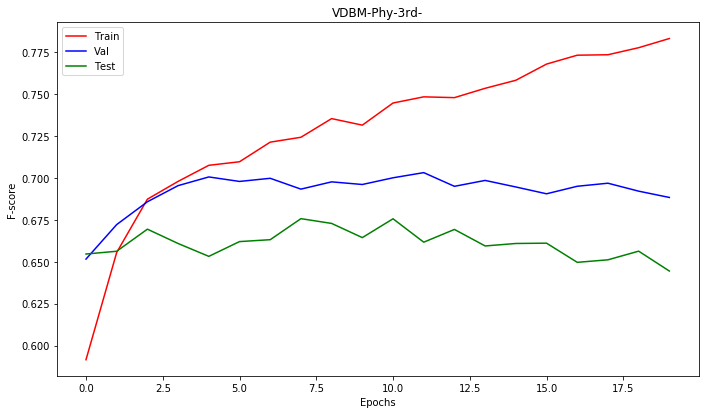

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=20=#==#==#==#==#=


100%|██████████| 2517/2517 [25:07<00:00,  1.67it/s]


==========Epoch No:20==========
Training Loss: 1141.39894578
Train: (0.7981926129918114, 0.7993643226062773, 0.7930195525761462, None)
                    0            1
Precision    0.788889     0.803561
Recall       0.616721     0.904762
F-score      0.692261     0.851164
Count      921.000000  1596.000000
--------
Val: (0.6875951854581185, 0.6777777777777778, 0.6808468481118314, None)
                    0           1
Precision    0.572464    0.759887
Recall       0.650206    0.695090
F-score      0.608863    0.726046
Count      243.000000  387.000000
--------
Test: (0.6525352471451747, 0.6404066073697586, 0.6444150296119273, None)
                    0           1
Precision    0.520468    0.732584
Recall       0.599327    0.665306
F-score      0.557121    0.697326
Count      297.000000  490.000000




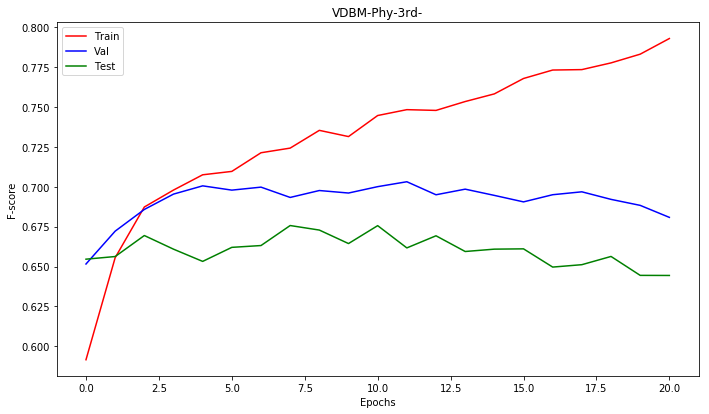

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=21=#==#==#==#==#=


100%|██████████| 2517/2517 [25:20<00:00,  1.65it/s]


==========Epoch No:21==========
Training Loss: 1139.92533228
Train: (0.7988007924260544, 0.7993643226062773, 0.7924384110291528, None)
                    0            1
Precision    0.794618     0.801215
Recall       0.609121     0.909148
F-score      0.689613     0.851776
Count      921.000000  1596.000000
--------
Val: (0.6895128618326377, 0.6793650793650794, 0.6824814374814376, None)
                    0           1
Precision    0.574007    0.762040
Recall       0.654321    0.695090
F-score      0.611538    0.727027
Count      243.000000  387.000000
--------
Test: (0.655009697050759, 0.6404066073697586, 0.6448552917354333, None)
                    0           1
Precision    0.520000    0.736842
Recall       0.612795    0.657143
F-score      0.562597    0.694714
Count      297.000000  490.000000




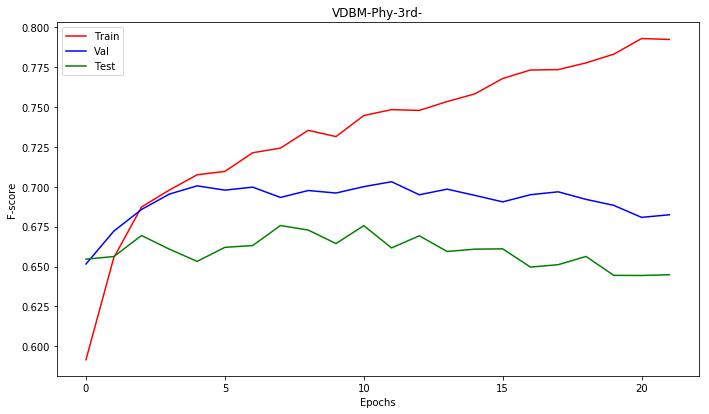

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=22=#==#==#==#==#=


100%|██████████| 2517/2517 [25:17<00:00,  1.66it/s]


==========Epoch No:22==========
Training Loss: 1116.4264705
Train: (0.8082340946279386, 0.8085021851410409, 0.802329113940194, None)
                    0            1
Precision    0.806137     0.809444
Recall       0.627579     0.912907
F-score      0.705739     0.858068
Count      921.000000  1596.000000
--------
Val: (0.6886904761904761, 0.680952380952381, 0.6835824501011565, None)
                    0           1
Precision    0.577778    0.758333
Recall       0.641975    0.705426
F-score      0.608187    0.730924
Count      243.000000  387.000000
--------
Test: (0.655646612698089, 0.6429479034307497, 0.6470446832924981, None)
                    0           1
Precision    0.523256    0.735892
Recall       0.606061    0.665306
F-score      0.561622    0.698821
Count      297.000000  490.000000




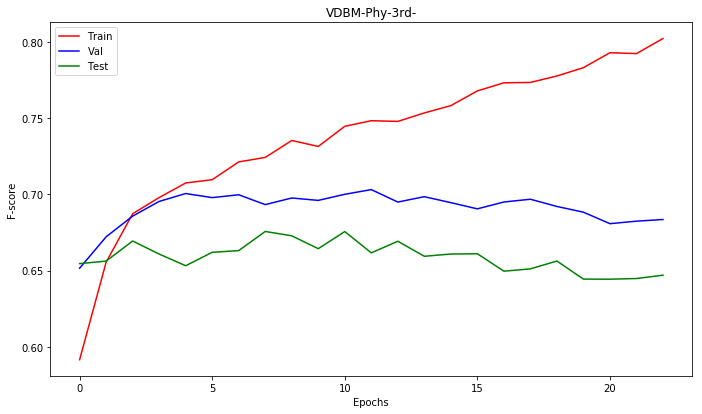

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=23=#==#==#==#==#=


100%|██████████| 2517/2517 [25:23<00:00,  1.65it/s]


==========Epoch No:23==========
Training Loss: 1104.64398031
Train: (0.8100569497795993, 0.8100913786253476, 0.8038915292858829, None)
                    0            1
Precision    0.809790     0.810211
Recall       0.628664     0.914787
F-score      0.707824     0.859329
Count      921.000000  1596.000000
--------
Val: (0.6830107583938023, 0.6761904761904762, 0.6786285714285715, None)
                    0           1
Precision    0.573034    0.752066
Recall       0.629630    0.705426
F-score      0.600000    0.728000
Count      243.000000  387.000000
--------
Test: (0.6578913708380654, 0.6467598475222364, 0.6505150758399034, None)
                    0           1
Precision    0.528024    0.736607
Recall       0.602694    0.673469
F-score      0.562893    0.703625
Count      297.000000  490.000000




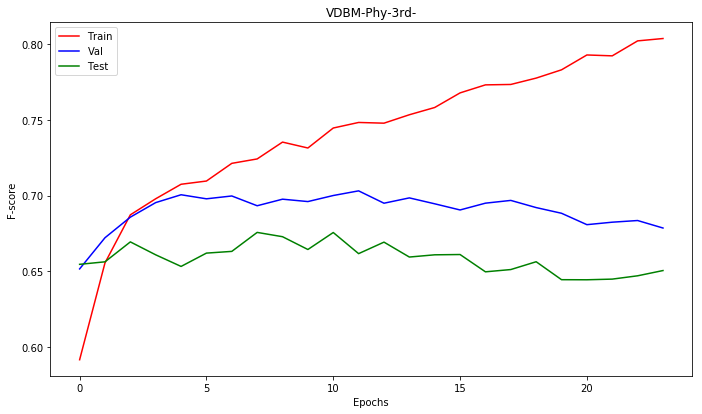

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=24=#==#==#==#==#=


 89%|████████▊ | 2231/2517 [21:15<02:43,  1.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [23:54<00:00,  1.76it/s]


==========Epoch No:25==========
Training Loss: 1077.67608944
Train: (0.8158448963888917, 0.8164481525625745, 0.8113365414734868, None)
                    0            1
Precision    0.810555     0.818898
Recall       0.650380     0.912281
F-score      0.721687     0.863071
Count      921.000000  1596.000000
--------
Val: (0.679954579597202, 0.6714285714285714, 0.6742845972688939, None)
                    0           1
Precision    0.566176    0.751397
Recall       0.633745    0.695090
F-score      0.598058    0.722148
Count      243.000000  387.000000
--------
Test: (0.6559872556557439, 0.6442185514612452, 0.648124492798725, None)
                    0           1
Precision    0.524927    0.735426
Recall       0.602694    0.669388
F-score      0.561129    0.700855
Count      297.000000  490.000000




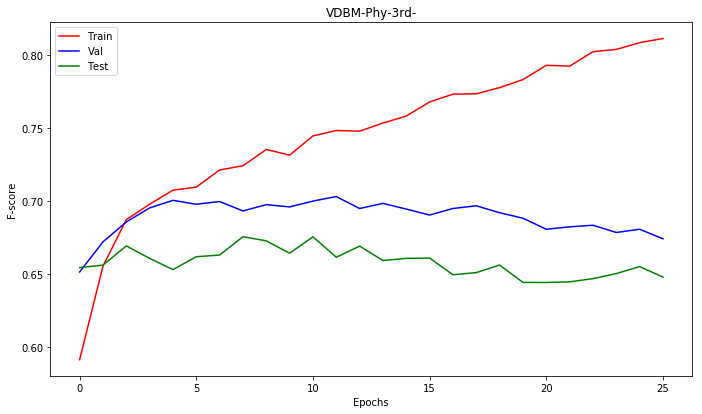

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=26=#==#==#==#==#=


100%|██████████| 2517/2517 [23:50<00:00,  1.76it/s]


==========Epoch No:26==========
Training Loss: 1065.77244496
Train: (0.8233278790431959, 0.8228049264998013, 0.8173805148877255, None)
                    0            1
Precision    0.827586     0.820871
Recall       0.651466     0.921679
F-score      0.729040     0.868359
Count      921.000000  1596.000000
--------
Val: (0.6700157307481251, 0.6603174603174603, 0.6634848942126571, None)
                    0           1
Precision    0.552727    0.743662
Recall       0.625514    0.682171
F-score      0.586873    0.711590
Count      243.000000  387.000000
--------
Test: (0.6575404432014319, 0.6454891994917408, 0.649440965589144, None)
                    0           1
Precision    0.526316    0.737079
Recall       0.606061    0.669388
F-score      0.563380    0.701604
Count      297.000000  490.000000




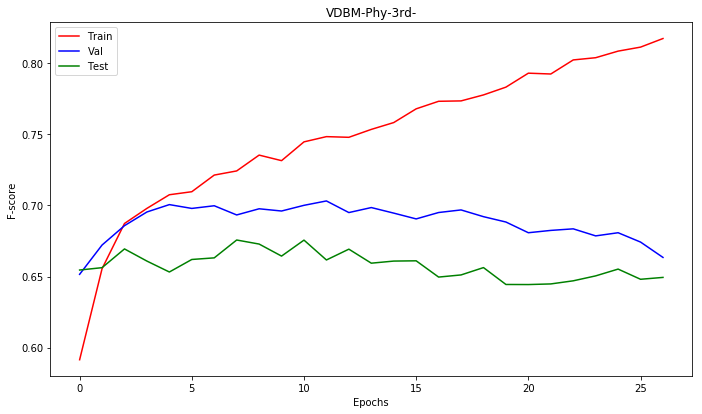

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=27=#==#==#==#==#=


  3%|▎         | 83/2517 [00:44<21:34,  1.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [22:42<00:00,  1.85it/s]


==========Epoch No:28==========
Training Loss: 1051.1542449
Train: (0.8249259913820307, 0.8247914183551848, 0.8198097824315853, None)
                    0            1
Precision    0.826087     0.824256
Recall       0.660152     0.919799
F-score      0.733856     0.869411
Count      921.000000  1596.000000
--------
Val: (0.6716978169595609, 0.6587301587301587, 0.6624609796389623, None)
                    0           1
Precision    0.549296    0.748555
Recall       0.641975    0.669251
F-score      0.592030    0.706685
Count      243.000000  387.000000
--------
Test: (0.6532406732351531, 0.6353240152477764, 0.640281442625983, None)
                    0           1
Precision    0.513889    0.737705
Recall       0.622896    0.642857
F-score      0.563166    0.687023
Count      297.000000  490.000000




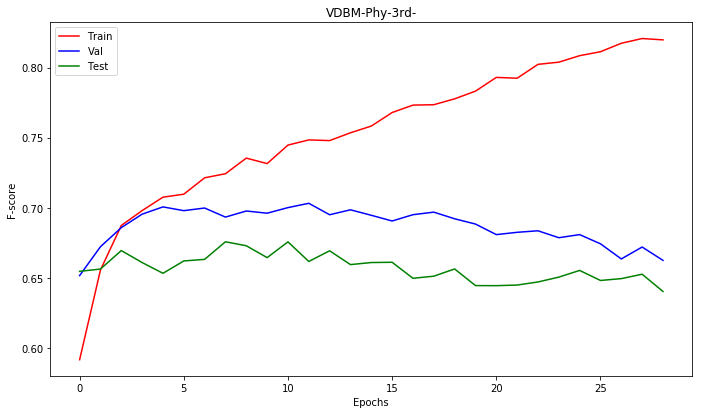

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=29=#==#==#==#==#=


100%|██████████| 2517/2517 [22:38<00:00,  1.85it/s]


==========Epoch No:29==========
Training Loss: 1042.86522271
Train: (0.8297087677064788, 0.8299562971791815, 0.8256747308267935, None)
                    0            1
Precision    0.827357     0.831066
Recall       0.676439     0.918546
F-score      0.744325     0.872619
Count      921.000000  1596.000000
--------
Val: (0.68499000999001, 0.6714285714285714, 0.6751187431494337, None)
                    0           1
Precision    0.562937    0.761628
Recall       0.662551    0.677003
F-score      0.608696    0.716826
Count      243.000000  387.000000
--------
Test: (0.6490850803533945, 0.636594663278272, 0.6407055888787007, None)
                    0           1
Precision    0.516035    0.729730
Recall       0.595960    0.661224
F-score      0.553125    0.693790
Count      297.000000  490.000000




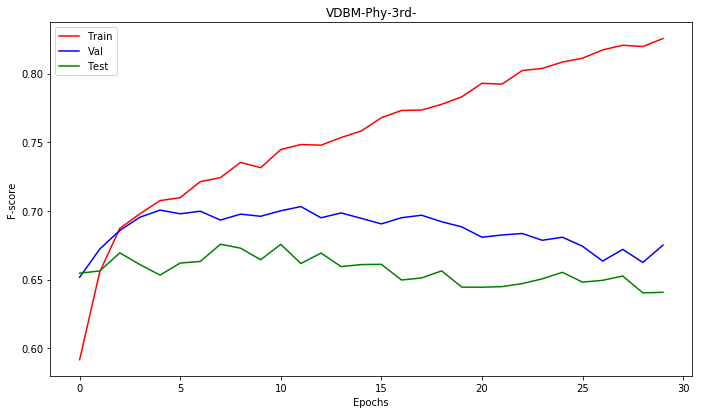

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=30=#==#==#==#==#=


100%|██████████| 2517/2517 [23:20<00:00,  1.80it/s]


==========Epoch No:30==========
Training Loss: 1025.22009312
Train: (0.8357140281897332, 0.8355184743742551, 0.8313151899961974, None)
                    0            1
Precision    0.837550     0.834655
Recall       0.682953     0.923559
F-score      0.752392     0.876859
Count      921.000000  1596.000000
--------
Val: (0.6687984700143874, 0.6587301587301587, 0.6619806519411022, None)
                    0           1
Precision    0.550725    0.742938
Recall       0.625514    0.679587
F-score      0.585742    0.709852
Count      243.000000  387.000000
--------
Test: (0.6559460653792143, 0.6416772554002541, 0.6460596990244891, None)
                    0           1
Precision    0.521490    0.737443
Recall       0.612795    0.659184
F-score      0.563467    0.696121
Count      297.000000  490.000000




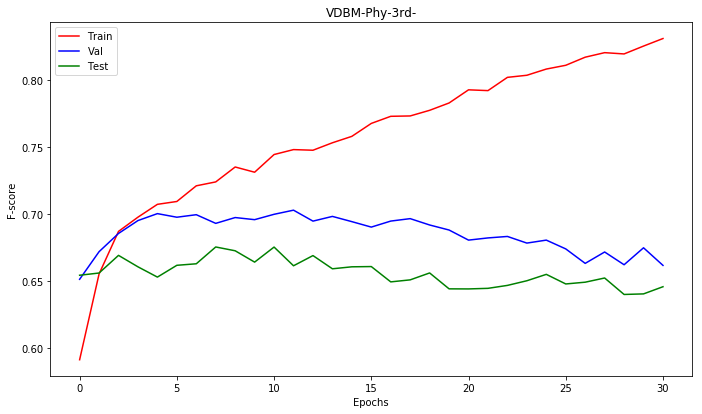

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=31=#==#==#==#==#=


100%|██████████| 2517/2517 [23:17<00:00,  1.80it/s]


==========Epoch No:31==========
Training Loss: 1011.30890492
Train: (0.846765916297479, 0.8454509336511721, 0.841236625523666, None)
                    0            1
Precision    0.858491     0.840000
Recall       0.691640     0.934211
F-score      0.766085     0.884604
Count      921.000000  1596.000000
--------
Val: (0.679908466819222, 0.6666666666666666, 0.6703614008941877, None)
                    0           1
Precision    0.557895    0.756522
Recall       0.654321    0.674419
F-score      0.602273    0.713115
Count      243.000000  387.000000
--------
Test: (0.64847916499327, 0.636594663278272, 0.6405843033586976, None)
                    0           1
Precision    0.516129    0.728700
Recall       0.592593    0.663265
F-score      0.551724    0.694444
Count      297.000000  490.000000




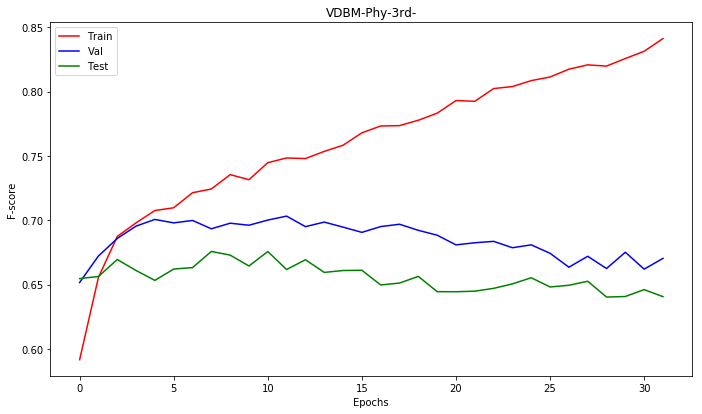

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=32=#==#==#==#==#=


100%|██████████| 2517/2517 [23:09<00:00,  1.81it/s]


==========Epoch No:32==========
Training Loss: 1001.75594249
Train: (0.8508288626905652, 0.8502185141040922, 0.8466967297006969, None)
                    0            1
Precision    0.856955     0.847293
Recall       0.709012     0.931704
F-score      0.775995     0.887496
Count      921.000000  1596.000000
--------
Val: (0.680114892317672, 0.6698412698412698, 0.6730501930501931, None)
                    0           1
Precision    0.563177    0.753541
Recall       0.641975    0.687339
F-score      0.600000    0.718919
Count      243.000000  387.000000
--------
Test: (0.6525067073517725, 0.6378653113087674, 0.6423454351399239, None)
                    0           1
Precision    0.517143    0.734554
Recall       0.609428    0.655102
F-score      0.559505    0.692557
Count      297.000000  490.000000




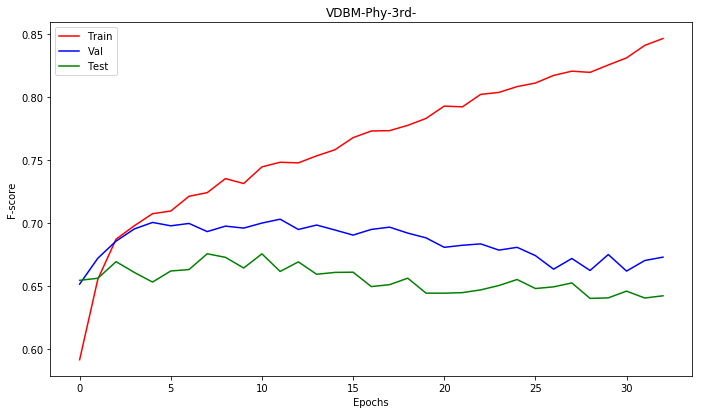

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=33=#==#==#==#==#=


100%|██████████| 2517/2517 [23:11<00:00,  1.81it/s]


==========Epoch No:33==========
Training Loss: 991.549692959
Train: (0.8468947620849273, 0.8462455303933254, 0.842460175733861, None)
                    0            1
Precision    0.853175     0.843271
Recall       0.700326     0.930451
F-score      0.769231     0.884718
Count      921.000000  1596.000000
--------
Val: (0.6764897959183673, 0.665079365079365, 0.6685193634025003, None)
                    0           1
Precision    0.557143    0.751429
Recall       0.641975    0.679587
F-score      0.596558    0.713704
Count      243.000000  387.000000
--------
Test: (0.6578913708380654, 0.6467598475222364, 0.6505150758399034, None)
                    0           1
Precision    0.528024    0.736607
Recall       0.602694    0.673469
F-score      0.562893    0.703625
Count      297.000000  490.000000




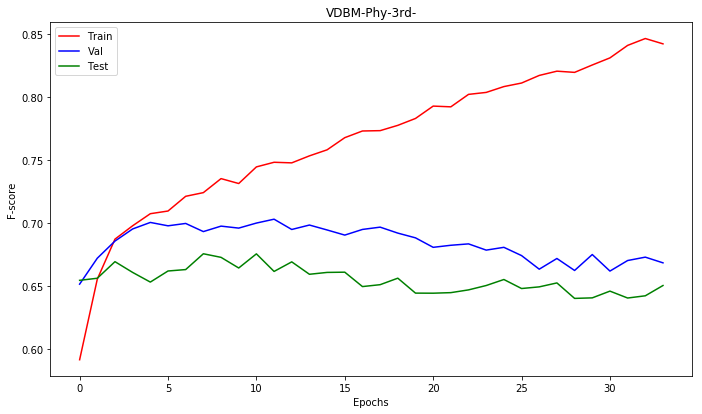

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=34=#==#==#==#==#=


100%|██████████| 2517/2517 [22:53<00:00,  1.83it/s]


==========Epoch No:34==========
Training Loss: 975.132643878
Train: (0.8491458566303948, 0.8486293206197855, 0.8450701698036222, None)
                    0            1
Precision    0.854331     0.846154
Recall       0.706840     0.930451
F-score      0.773619     0.886303
Count      921.000000  1596.000000
--------
Val: (0.679908466819222, 0.6666666666666666, 0.6703614008941877, None)
                    0           1
Precision    0.557895    0.756522
Recall       0.654321    0.674419
F-score      0.602273    0.713115
Count      243.000000  387.000000
--------
Test: (0.6559460653792143, 0.6416772554002541, 0.6460596990244891, None)
                    0           1
Precision    0.521490    0.737443
Recall       0.612795    0.659184
F-score      0.563467    0.696121
Count      297.000000  490.000000




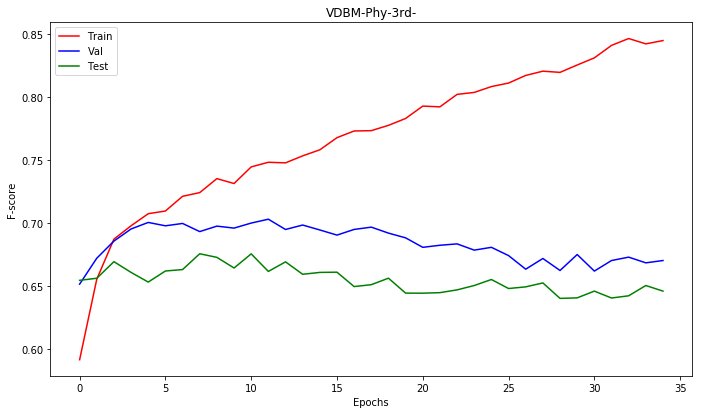

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=35=#==#==#==#==#=


100%|██████████| 2517/2517 [22:25<00:00,  1.87it/s]


==========Epoch No:35==========
Training Loss: 968.071480483
Train: (0.853748357687021, 0.8533969010727056, 0.8502147323925253, None)
                    0            1
Precision    0.857513     0.851576
Recall       0.718784     0.931078
F-score      0.782044     0.889554
Count      921.000000  1596.000000
--------
Val: (0.6642040431894697, 0.6476190476190476, 0.6518868758025186, None)
                    0           1
Precision    0.535836    0.744807
Recall       0.646091    0.648579
F-score      0.585821    0.693370
Count      243.000000  387.000000
--------
Test: (0.6482278626033704, 0.6302414231257941, 0.6352679435685052, None)
                    0           1
Precision    0.508333    0.733021
Recall       0.616162    0.638776
F-score      0.557078    0.682661
Count      297.000000  490.000000




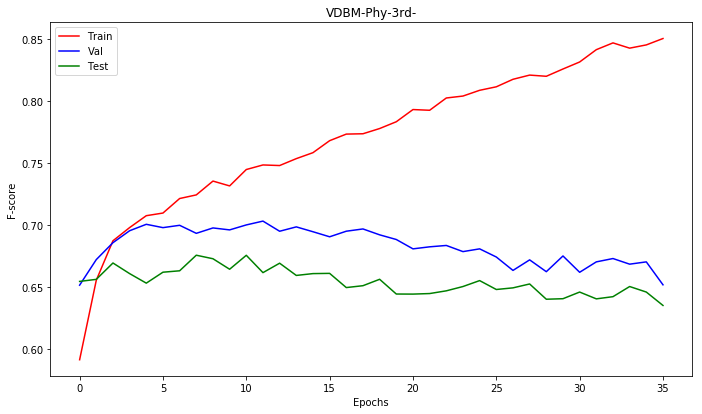

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=36=#==#==#==#==#=


100%|██████████| 2517/2517 [22:45<00:00,  1.84it/s]


==========Epoch No:36==========
Training Loss: 955.473558336
Train: (0.853919856553481, 0.8533969010727056, 0.8501096025350818, None)
                    0            1
Precision    0.859375     0.850772
Recall       0.716612     0.932331
F-score      0.781528     0.889686
Count      921.000000  1596.000000
--------
Val: (0.6645885250651985, 0.6492063492063492, 0.6533335889460289, None)
                    0           1
Precision    0.537931    0.744118
Recall       0.641975    0.653747
F-score      0.585366    0.696011
Count      243.000000  387.000000
--------
Test: (0.6534432390431066, 0.639135959339263, 0.6435494841239535, None)
                    0           1
Precision    0.518625    0.735160
Recall       0.609428    0.657143
F-score      0.560372    0.693966
Count      297.000000  490.000000




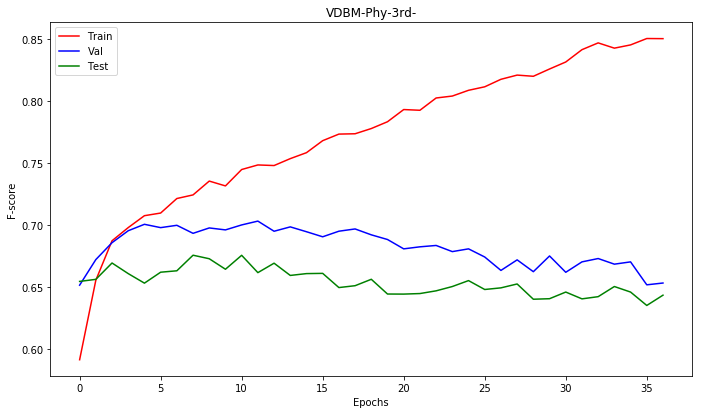

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=37=#==#==#==#==#=


100%|██████████| 2517/2517 [22:29<00:00,  1.87it/s]


==========Epoch No:37==========
Training Loss: 937.820781708
Train: (0.8616942566295998, 0.8613428684942391, 0.858577250858779, None)
                    0            1
Precision    0.865729     0.859366
Recall       0.735071     0.934211
F-score      0.795068     0.895227
Count      921.000000  1596.000000
--------
Val: (0.6901376892775829, 0.6730158730158731, 0.6770430282318984, None)
                    0           1
Precision    0.562712    0.770149
Recall       0.683128    0.666667
F-score      0.617100    0.714681
Count      243.000000  387.000000
--------
Test: (0.6465652599268816, 0.6315120711562897, 0.6361214863929054, None)
                    0           1
Precision    0.509972    0.729358
Recall       0.602694    0.648980
F-score      0.552469    0.686825
Count      297.000000  490.000000




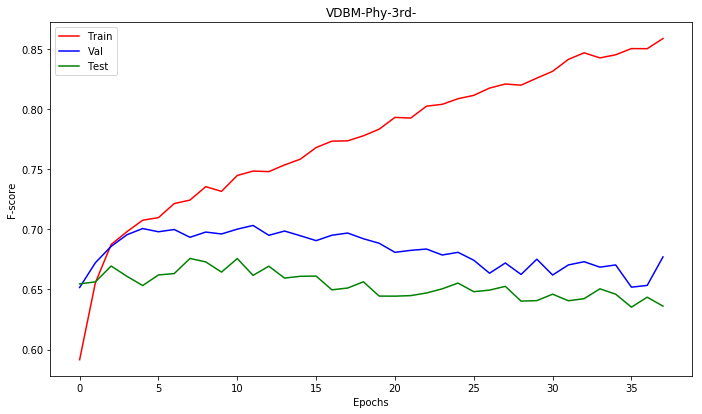

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=38=#==#==#==#==#=


100%|██████████| 2517/2517 [22:49<00:00,  1.84it/s]


==========Epoch No:38==========
Training Loss: 922.235343277
Train: (0.8659458527766469, 0.865315852205006, 0.8625825595973149, None)
                    0            1
Precision    0.873077     0.861831
Recall       0.739414     0.937970
F-score      0.800705     0.898290
Count      921.000000  1596.000000
--------
Val: (0.6739988409156766, 0.6587301587301587, 0.6627453467122002, None)
                    0           1
Precision    0.548276    0.752941
Recall       0.654321    0.661499
F-score      0.596623    0.704264
Count      243.000000  387.000000
--------
Test: (0.6565926768582164, 0.6442185514612452, 0.6482432338672595, None)
                    0           1
Precision    0.524781    0.736486
Recall       0.606061    0.667347
F-score      0.562500    0.700214
Count      297.000000  490.000000




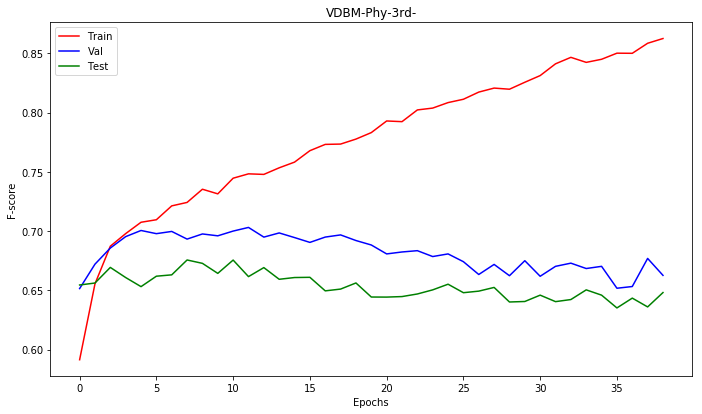

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=39=#==#==#==#==#=


100%|██████████| 2517/2517 [23:25<00:00,  1.79it/s]


==========Epoch No:39==========
Training Loss: 908.691046178
Train: (0.8689458732551489, 0.8684942391736193, 0.8660072490098343, None)
                    0            1
Precision    0.874365     0.865818
Recall       0.748100     0.937970
F-score      0.806319     0.900451
Count      921.000000  1596.000000
--------
Val: (0.674939393939394, 0.6555555555555556, 0.6599428249998074, None)
                    0           1
Precision    0.543333    0.757576
Recall       0.670782    0.645995
F-score      0.600368    0.697350
Count      243.000000  387.000000
--------
Test: (0.6490684455141281, 0.6340533672172808, 0.6386309933832993, None)
                    0           1
Precision    0.512821    0.731651
Recall       0.606061    0.651020
F-score      0.555556    0.688985
Count      297.000000  490.000000




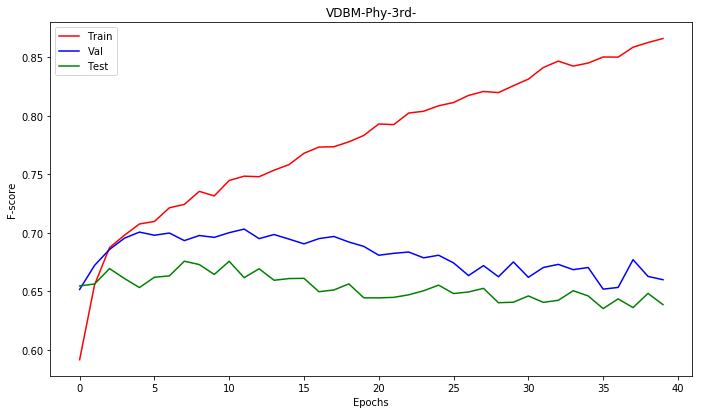

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=40=#==#==#==#==#=


100%|██████████| 2517/2517 [23:22<00:00,  1.79it/s]


==========Epoch No:40==========
Training Loss: 901.402279019
Train: (0.8668678710043006, 0.8661104489471593, 0.8633463931272433, None)
                    0            1
Precision    0.875321     0.861990
Recall       0.739414     0.939223
F-score      0.801648     0.898951
Count      921.000000  1596.000000
--------
Val: (0.6685642758283808, 0.6555555555555556, 0.6593210817751385, None)
                    0           1
Precision    0.545775    0.745665
Recall       0.637860    0.666667
F-score      0.588235    0.703956
Count      243.000000  387.000000
--------
Test: (0.6553208261442574, 0.6416772554002541, 0.645954967989395, None)
                    0           1
Precision    0.521614    0.736364
Recall       0.609428    0.661224
F-score      0.562112    0.696774
Count      297.000000  490.000000




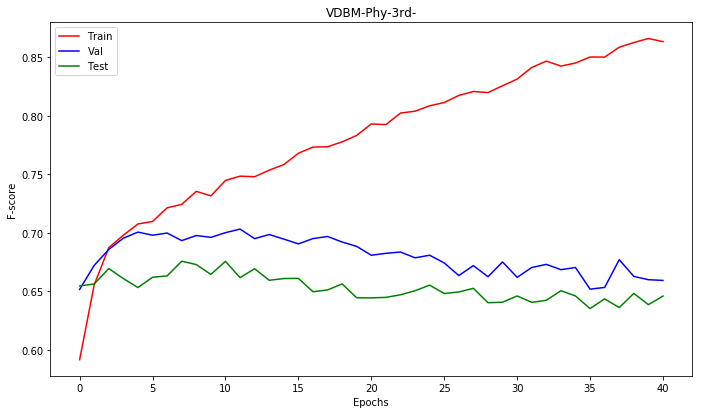

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=41=#==#==#==#==#=


100%|██████████| 2517/2517 [23:03<00:00,  1.82it/s]


==========Epoch No:41==========
Training Loss: 884.108855128
Train: (0.8748963559530124, 0.8744537147397695, 0.8722282881996827, None)
                    0            1
Precision    0.880503     0.871661
Recall       0.760043     0.940476
F-score      0.815851     0.904762
Count      921.000000  1596.000000
--------
Val: (0.664689235929148, 0.6523809523809524, 0.656069970845481, None)
                    0           1
Precision    0.542553    0.741379
Recall       0.629630    0.666667
F-score      0.582857    0.702041
Count      243.000000  387.000000
--------
Test: (0.655646612698089, 0.6429479034307497, 0.6470446832924981, None)
                    0           1
Precision    0.523256    0.735892
Recall       0.606061    0.665306
F-score      0.561622    0.698821
Count      297.000000  490.000000




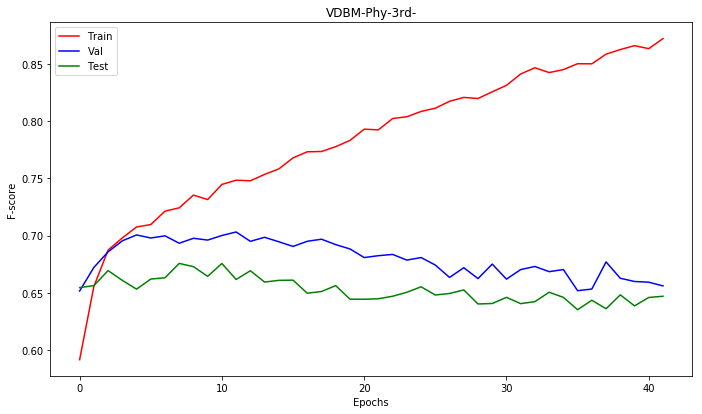

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=42=#==#==#==#==#=


100%|██████████| 2517/2517 [22:53<00:00,  1.83it/s]


==========Epoch No:42==========
Training Loss: 871.615597233
Train: (0.8788832661686521, 0.8784266984505363, 0.8763528576618349, None)
                    0            1
Precision    0.884856     0.875437
Recall       0.767644     0.942356
F-score      0.822093     0.907664
Count      921.000000  1596.000000
--------
Val: (0.6767609923219042, 0.6603174603174603, 0.664431492890716, None)
                    0           1
Precision    0.549488    0.756677
Recall       0.662551    0.658915
F-score      0.600746    0.704420
Count      243.000000  387.000000
--------
Test: (0.6562866488847896, 0.6404066073697586, 0.6450458039714857, None)
                    0           1
Precision    0.519774    0.739030
Recall       0.619529    0.653061
F-score      0.565284    0.693391
Count      297.000000  490.000000




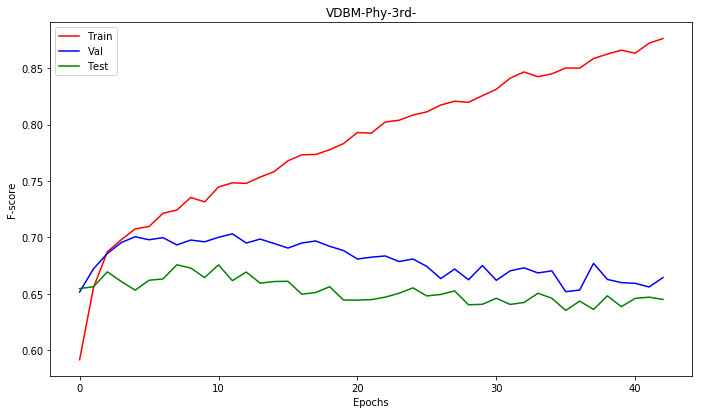

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=43=#==#==#==#==#=


100%|██████████| 2517/2517 [18:07<00:00,  2.31it/s]


==========Epoch No:43==========
Training Loss: 864.729207873
Train: (0.8779827723326539, 0.877632101708383, 0.8755852216240979, None)
                    0            1
Precision    0.882647     0.875291
Recall       0.767644     0.941103
F-score      0.821138     0.907005
Count      921.000000  1596.000000
--------
Val: (0.6810674046711981, 0.665079365079365, 0.6690988444362598, None)
                    0           1
Precision    0.554795    0.760355
Recall       0.666667    0.664083
F-score      0.605607    0.708966
Count      243.000000  387.000000
--------
Test: (0.655498549543286, 0.636594663278272, 0.6416441685040553, None)
                    0           1
Precision    0.515152    0.740566
Recall       0.629630    0.640816
F-score      0.566667    0.687090
Count      297.000000  490.000000




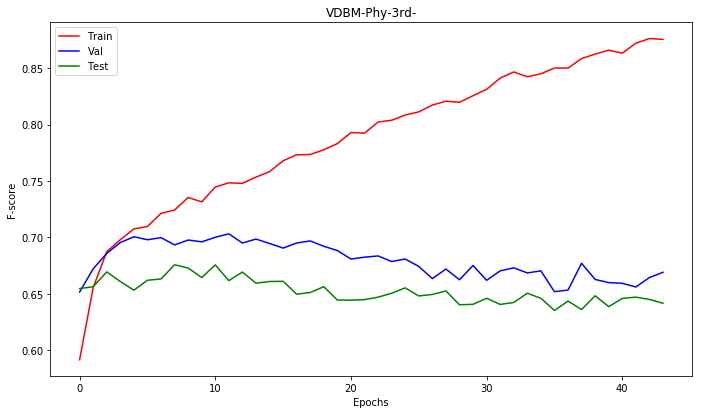

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=44=#==#==#==#==#=


100%|██████████| 2517/2517 [16:17<00:00,  2.57it/s]


==========Epoch No:44==========
Training Loss: 855.250558168
Train: (0.8838557627180929, 0.8835915772745332, 0.8818152446670239, None)
                    0            1
Precision    0.887654     0.881664
Recall       0.780673     0.942982
F-score      0.830734     0.911293
Count      921.000000  1596.000000
--------
Val: (0.6728916057008439, 0.6603174603174603, 0.6639774912047267, None)
                    0           1
Precision    0.551237    0.749280
Recall       0.641975    0.671835
F-score      0.593156    0.708447
Count      243.000000  387.000000
--------
Test: (0.6496972117987531, 0.636594663278272, 0.6408218321703862, None)
                    0           1
Precision    0.515942    0.730769
Recall       0.599327    0.659184
F-score      0.554517    0.693133
Count      297.000000  490.000000




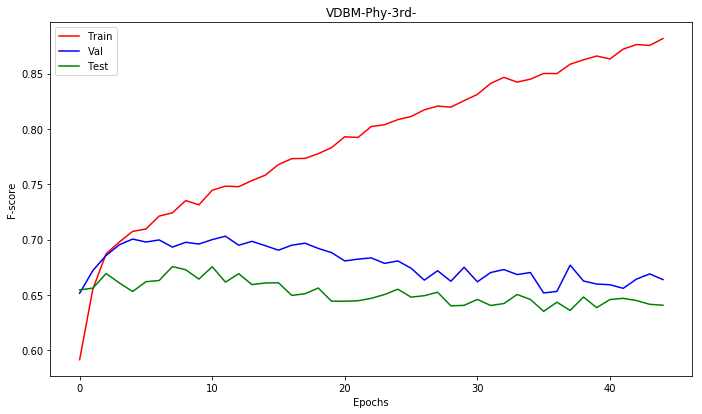

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=45=#==#==#==#==#=


 89%|████████▉ | 2246/2517 [14:40<01:46,  2.55it/s]

==========Epoch No:45==========
Training Loss: 835.388804346
Train: (0.8858727490571394, 0.8851807707588399, 0.8832411770845637, None)
                    0            1
Precision    0.895000     0.880606
Recall       0.777416     0.947368
F-score      0.832074     0.912768
Count      921.000000  1596.000000
--------
Val: (0.680671671356447, 0.6666666666666666, 0.6704574825536315, None)
                    0           1
Precision    0.557491    0.758017
Recall       0.658436    0.671835
F-score      0.603774    0.712329
Count      243.000000  387.000000
--------
Test: (0.6562866488847896, 0.6404066073697586, 0.6450458039714857, None)
                    0           1
Precision    0.519774    0.739030
Recall       0.619529    0.653061
F-score      0.565284    0.693391
Count      297.000000  490.000000




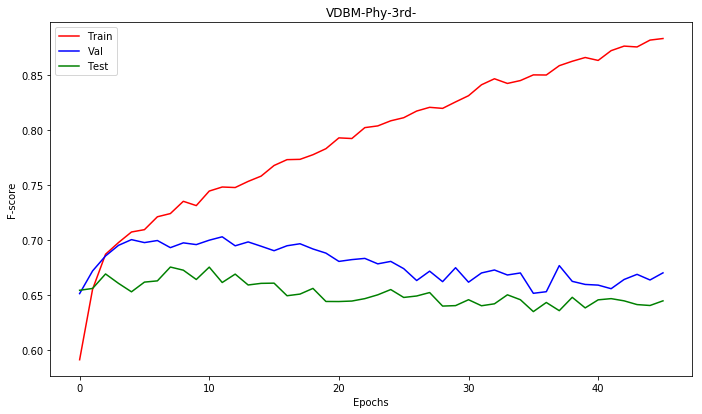

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=46=#==#==#==#==#=


100%|██████████| 2517/2517 [16:21<00:00,  2.56it/s]


==========Epoch No:46==========
Training Loss: 820.615437001
Train: (0.8886583075730461, 0.8883591577274533, 0.8867271138129472, None)
                    0            1
Precision    0.893120     0.886083
Recall       0.789359     0.945489
F-score      0.838040     0.914823
Count      921.000000  1596.000000
--------
Val: (0.6800876510921043, 0.6603174603174603, 0.6646674451903667, None)
                    0           1
Precision    0.548173    0.762918
Recall       0.679012    0.648579
F-score      0.606618    0.701117
Count      243.000000  387.000000
--------
Test: (0.6536677577537535, 0.6340533672172808, 0.6392054621095747, None)
                    0           1
Precision    0.512329    0.739336
Recall       0.629630    0.636735
F-score      0.564955    0.684211
Count      297.000000  490.000000




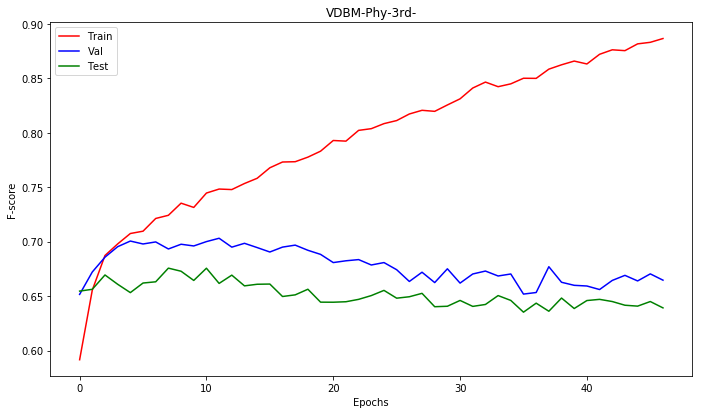

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=47=#==#==#==#==#=


 19%|█▉        | 476/2517 [02:56<12:37,  2.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [16:03<00:00,  2.61it/s]


==========Epoch No:48==========
Training Loss: 791.080828875
Train: (0.8947134880653286, 0.8939213349225268, 0.8922339022841939, None)
                    0            1
Precision    0.905707     0.888369
Recall       0.792617     0.952381
F-score      0.845397     0.919262
Count      921.000000  1596.000000
--------
Val: (0.6752544752544752, 0.6571428571428571, 0.6614285714285715, None)
                    0           1
Precision    0.545455    0.756757
Recall       0.666667    0.651163
F-score      0.600000    0.700000
Count      243.000000  387.000000
--------
Test: (0.6540748166886213, 0.639135959339263, 0.6436500073640868, None)
                    0           1
Precision    0.518519    0.736239
Recall       0.612795    0.655102
F-score      0.561728    0.693305
Count      297.000000  490.000000




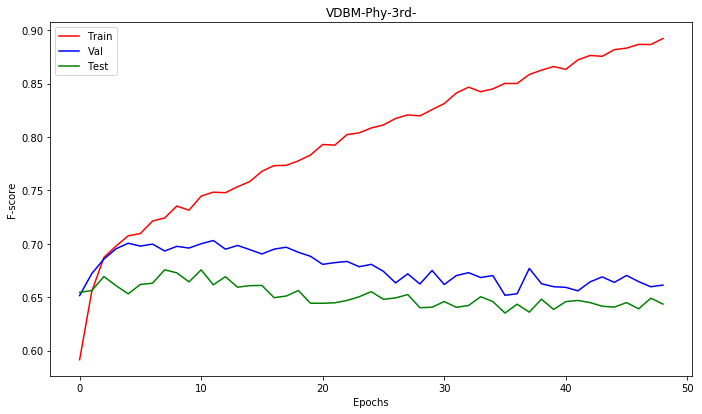

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=49=#==#==#==#==#=


 56%|█████▌    | 1403/2517 [09:00<07:09,  2.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [16:42<00:00,  2.51it/s]


==========Epoch No:50==========
Training Loss: 769.723565638
Train: (0.9030292625377188, 0.9026618990862137, 0.9014219478948468, None)
                    0            1
Precision    0.909201     0.899468
Recall       0.815418     0.953008
F-score      0.859760     0.925464
Count      921.000000  1596.000000
--------
Val: (0.6724597531320221, 0.6634920634920635, 0.6664898367449005, None)
                    0           1
Precision    0.556777    0.745098
Recall       0.625514    0.687339
F-score      0.589147    0.715054
Count      243.000000  387.000000
--------
Test: (0.6478451015756168, 0.6315120711562897, 0.6363116873594726, None)
                    0           1
Precision    0.509859    0.731481
Recall       0.609428    0.644898
F-score      0.555215    0.685466
Count      297.000000  490.000000




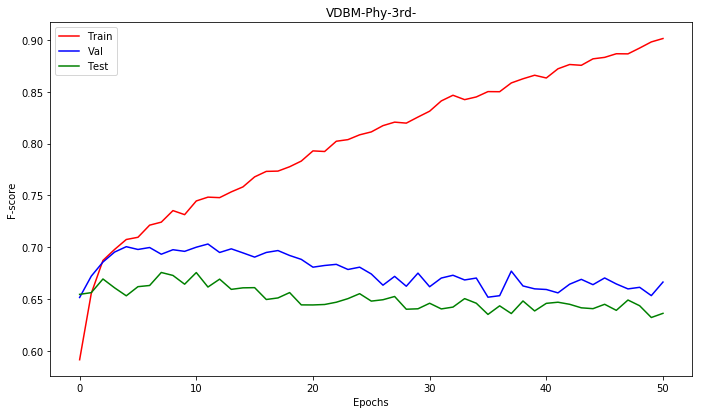

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=51=#==#==#==#==#=


 90%|█████████ | 2277/2517 [15:52<01:40,  2.39it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [16:56<00:00,  2.48it/s]


==========Epoch No:53==========
Training Loss: 747.200631261
Train: (0.907808602249591, 0.9074294795391339, 0.906306980860037, None)
                    0            1
Precision    0.914458     0.903972
Recall       0.824104     0.955514
F-score      0.866933     0.929028
Count      921.000000  1596.000000
--------
Val: (0.6815530756042029, 0.6698412698412698, 0.6732895547864018, None)
                    0           1
Precision    0.562278    0.756447
Recall       0.650206    0.682171
F-score      0.603053    0.717391
Count      243.000000  387.000000
--------
Test: (0.6462518331362482, 0.6327827191867853, 0.6371110558027387, None)
                    0           1
Precision    0.511561    0.727891
Recall       0.595960    0.655102
F-score      0.550544    0.689581
Count      297.000000  490.000000




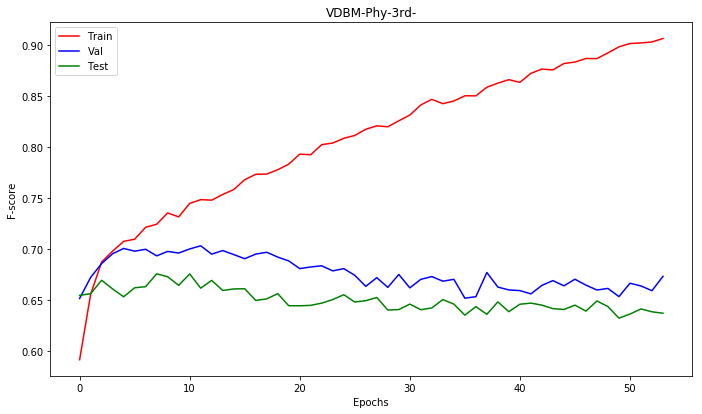

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=54=#==#==#==#==#=


 27%|██▋       | 684/2517 [04:32<12:10,  2.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [16:52<00:00,  2.49it/s]


==========Epoch No:55==========
Training Loss: 722.068720132
Train: (0.9134608659630832, 0.9129916567342073, 0.9119630340015661, None)
                    0            1
Precision    0.921875     0.908605
Recall       0.832790     0.959273
F-score      0.875071     0.933252
Count      921.000000  1596.000000
--------
Val: (0.6700157307481251, 0.6603174603174603, 0.6634848942126571, None)
                    0           1
Precision    0.552727    0.743662
Recall       0.625514    0.682171
F-score      0.586873    0.711590
Count      243.000000  387.000000
--------
Test: (0.6456366157418009, 0.6327827191867853, 0.6369961333506474, None)
                    0           1
Precision    0.511628    0.726862
Recall       0.592593    0.657143
F-score      0.549142    0.690247
Count      297.000000  490.000000




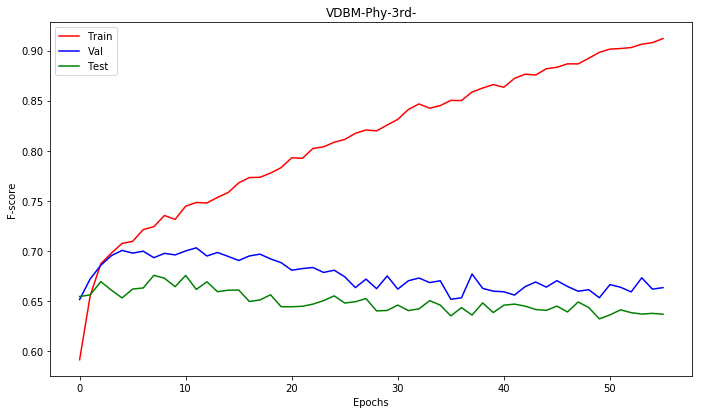

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=56=#==#==#==#==#=


 59%|█████▉    | 1496/2517 [10:17<07:01,  2.42it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [16:46<00:00,  2.50it/s]


==========Epoch No:57==========
Training Loss: 693.899933666
Train: (0.9198579961474467, 0.9193484306714342, 0.9184435378613806, None)
                    0            1
Precision    0.929426     0.914337
Recall       0.843648     0.963033
F-score      0.884462     0.938053
Count      921.000000  1596.000000
--------
Val: (0.6687984700143874, 0.6587301587301587, 0.6619806519411022, None)
                    0           1
Precision    0.550725    0.742938
Recall       0.625514    0.679587
F-score      0.585742    0.709852
Count      243.000000  387.000000
--------
Test: (0.6456366157418009, 0.6327827191867853, 0.6369961333506474, None)
                    0           1
Precision    0.511628    0.726862
Recall       0.592593    0.657143
F-score      0.549142    0.690247
Count      297.000000  490.000000




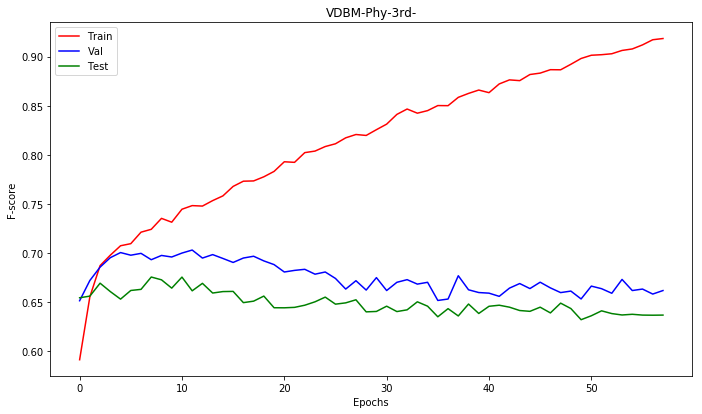

  0%|          | 0/2517 [00:00<?, ?it/s]

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  
=#==#==#==#==#=58=#==#==#==#==#=


 82%|████████▏ | 2062/2517 [13:58<03:05,  2.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2517/2517 [16:45<00:00,  2.50it/s]


==========Epoch No:59==========
Training Loss: 682.606777012
Train: (0.9204925336372222, 0.9201430274135876, 0.9193181708726621, None)
                    0            1
Precision    0.927553     0.916418
Recall       0.847991     0.961779
F-score      0.885990     0.938551
Count      921.000000  1596.000000
--------
Val: (0.6606777360066833, 0.6460317460317461, 0.650105454750778, None)
                    0           1
Precision    0.534722    0.739766
Recall       0.633745    0.653747
F-score      0.580038    0.694102
Count      243.000000  387.000000
--------
Test: (0.6484375863708912, 0.6340533672172808, 0.6385290543228824, None)
                    0           1
Precision    0.512894    0.730594
Recall       0.602694    0.653061
F-score      0.554180    0.689655
Count      297.000000  490.000000




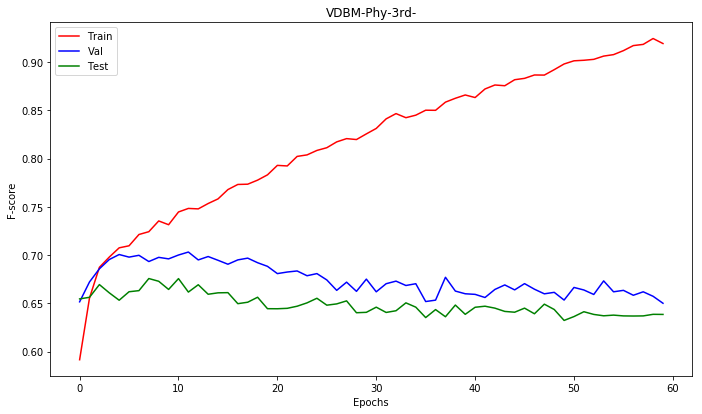

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  


In [8]:
start_epoch = 0
end_epoch = 60
model_name = params['model_name']
for iter_ in range(start_epoch, end_epoch):
    print "=#="*5+str(iter_)+"=#="*5
    total_loss = 0
    preds_train = []
    actual_train = []
    for each_ID in tqdm(data['train_ids']):
        model_RNN.zero_grad()
        tag_scores = model_RNN(data['data'], each_ID)
        
        _, ind_ = torch.max(tag_scores, dim=1)
        preds_train+=ind_.tolist()
        # For this dataset the label is in -2
        curr_labels = [data['data'][each_ID][label_ind]]
        curr_labels = [batchify.label_mapping[x] for x in curr_labels]
        actual_train+=curr_labels
        curr_labels = torch.cuda.LongTensor(curr_labels)
        curr_labels = autograd.Variable(curr_labels)
        
        loss = loss_function(tag_scores, curr_labels.reshape(tag_scores.shape[0]))
        total_loss+=loss.item()

        loss.backward()
        optimizer.step()
    
    df_tr = pd.DataFrame(list(precision_recall_fscore_support(actual_train, preds_train, 
                                                              labels = [0,1])),
                                                             columns = [0,1])
    df_tr.index = ['Precision','Recall','F-score','Count']
    prf_tr = precision_recall_fscore_support(actual_train, preds_train, average='weighted')
#     prf_tr, df_tr = evaluate_(model_RNN, data, 'train_ids')
    prf_test, df_test = eval_plot.evaluate_dbm(model_RNN, data, 'test_ids')
    prf_val, df_val = eval_plot.evaluate_dbm(model_RNN, data, 'val_ids')
    
    df_all = pd.concat([df_tr, df_val, df_test],axis=1)
    dict_df_prf_mod['Epoch'+str(iter_)] = df_all
    
    print '=='*5 + "Epoch No:"+str(iter_) +"=="*5
    print "Training Loss: "+str(total_loss)
    print "=="*4
    print "Train: " + str(prf_tr)
    print df_tr
    print "--"*4
    print "Val: " + str(prf_val)
    print df_val
    print "--"*4
    print "Test: " + str(prf_test)
    print df_test
    print '=='*40
    print '\n'
    if(save_flag):
        torch.save(model_RNN, '../../Models/'+model_name+str(iter_)+'.pt')
        pickle.dump(dict_df_prf_mod, open('../../Results/dict_prf_'+model_name+str(iter_)+'.pkl','wb'))
        eval_plot.plot_graphs(dict_df_prf_mod, 'F-score', 
                              '../../Plots/'+model_name+str(iter_)+'.png',
                              0, iter_+1, 
                              model_name)

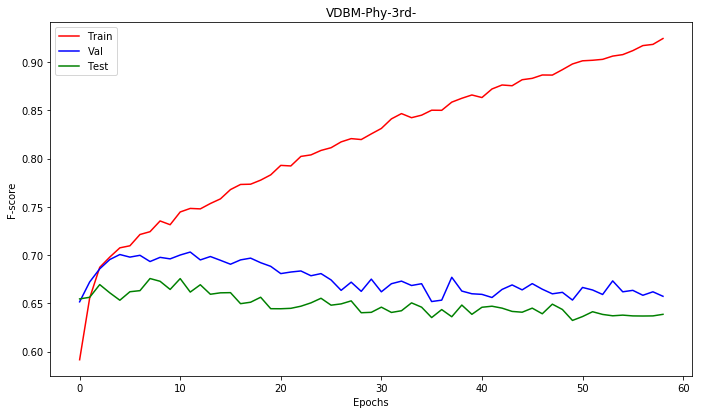

==========Epoch11========
TRAIN: (0.7563832901417995, 0.7592371871275327, 0.7484066281749127)
VAL: (0.7057020054324636, 0.7015873015873015, 0.7031934080489202)
TEST: (0.6628273216209535, 0.6607369758576874, 0.6616965097501539)
======== Detailed Results ========
                    0            1           0           1           0  \
Precision    0.738998     0.766416    0.606178    0.768194    0.549020   
Recall       0.528773     0.892231    0.646091    0.736434    0.565657   
F-score      0.616456     0.824551    0.625498    0.751979    0.557214   
Count      921.000000  1596.000000  243.000000  387.000000  297.000000   

                    1  
Precision    0.731809  
Recall       0.718367  
F-score      0.725026  
Count      490.000000  


In [9]:
        eval_plot.plot_graphs(dict_df_prf_mod, 'F-score', 
                              '../../Plots/'+model_name+str(iter_)+'.png',
                              0, iter_, 
                              model_name)